In [ ]:
!kaggle datasets download -d arashnic/book-recommendation-dataset
!unzip book-recommendation-dataset.zip
!ls

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
 90% 22.0M/24.3M [00:00<00:00, 72.2MB/s]
100% 24.3M/24.3M [00:00<00:00, 69.9MB/s]
Archive:  book-recommendation-dataset.zip
  inflating: Books.csv               
  inflating: DeepRec.png             
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: classicRec.png          
  inflating: recsys_taxonomy2.png    
book-recommendation-dataset.zip  classicRec.png  Ratings.csv	       sample_data
Books.csv			 DeepRec.png	 recsys_taxonomy2.png  Users.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from scipy.sparse import csr_matrix, vstack
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

In [ ]:
# Load the datasets
users = pd.read_csv('Users.csv', delimiter=',', encoding='ISO-8859-1')
books = pd.read_csv('Books.csv', delimiter=',', encoding='ISO-8859-1')
ratings = pd.read_csv('Ratings.csv', delimiter=',', encoding='ISO-8859-1')


<ipython-input-3-38abf8a8d748>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv', delimiter=',', encoding='ISO-8859-1')


In [ ]:
# Handle missing or invalid Age
users['Age'] = pd.to_numeric(users['Age'], errors='coerce')  # Convert to numeric, invalid entries become NaN
users.loc[(users['Age'] < 5) | (users['Age'] > 100), 'Age'] = np.nan  # Replace unrealistic ages with NaN
median_age = users['Age'].median()
users['Age'] = users['Age'].fillna(median_age)  # Fill missing ages with median

# Split Location into City, State, and Country
location_split = users['Location'].str.split(',', expand=True)
users['City'] = location_split[0].str.strip()  # Extract City
users['State'] = location_split[1].str.strip() if location_split.shape[1] > 1 else np.nan  # Extract State
users['Country'] = location_split[2].str.strip() if location_split.shape[1] > 2 else np.nan  # Extract Country

# Handle missing or inconsistent location data
users['Country'] = users['Country'].fillna('Unknown')  # Replace missing countries with 'Unknown'

encoder_country = LabelEncoder()
users['Country-Encoded'] = encoder_country.fit_transform(users['Country'])


In [ ]:
# Drop unnecessary image URL columns from books
books = books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], errors='ignore')

# Replace invalid years with NaN and then fill with median
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
median_year = books['Year-Of-Publication'].median()
books['Year-Of-Publication'] = books['Year-Of-Publication'].fillna(median_year)

# Normalize Year-Of-Publication
scaler = MinMaxScaler()
books[['Year-Of-Publication']] = scaler.fit_transform(books[['Year-Of-Publication']])

# Encode Book-Author and Publisher
encoder_author = LabelEncoder()
books['Book-Author-Encoded'] = encoder_author.fit_transform(books['Book-Author'])

encoder_publisher = LabelEncoder()
books['Publisher-Encoded'] = encoder_publisher.fit_transform(books['Publisher'])


In [ ]:
# Ensure Book-Rating is an integer and within the valid range (0-10)
ratings['Book-Rating'] = pd.to_numeric(ratings['Book-Rating'], errors='coerce')
ratings = ratings[(ratings['Book-Rating'] >= 0) & (ratings['Book-Rating'] <= 10)]

# Handle implicit and explicit interactions
explicit_ratings = ratings[ratings['Book-Rating'] > 0]
implicit_interactions = ratings[ratings['Book-Rating'] == 0]

# Normalize explicit ratings per user
explicit_ratings['Normalized-Rating'] = explicit_ratings.groupby('User-ID')['Book-Rating'].transform(
    lambda x: x - x.mean()
)

<ipython-input-6-7a4bfa179360>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  explicit_ratings['Normalized-Rating'] = explicit_ratings.groupby('User-ID')['Book-Rating'].transform(


In [ ]:
# Print Dataset
print("Users Data:")
print(users.head(), "\n")
print("Books Data:")
print(books.head(), "\n")
print("Ratings Data:")
print(ratings.head(), "\n")
print("Explicit Data:")
print(explicit_ratings.head(), "\n")
print("Implicit Data:")
print(implicit_interactions.head(), "\n")

Users Data:
   User-ID                            Location   Age         City  \
0        1                  nyc, new york, usa  32.0          nyc   
1        2           stockton, california, usa  18.0     stockton   
2        3     moscow, yukon territory, russia  32.0       moscow   
3        4           porto, v.n.gaia, portugal  17.0        porto   
4        5  farnborough, hants, united kingdom  32.0  farnborough   

             State         Country  Country-Encoded  
0         new york             usa             1001  
1       california             usa             1001  
2  yukon territory          russia              811  
3         v.n.gaia        portugal              763  
4            hants  united kingdom              984   

Books Data:
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                  

In [ ]:
#Content Based Filtering
# Merge Explicit Ratings with Books
merged = explicit_ratings.merge(books, on='ISBN', how='inner')

# Combine Features
merged['Combined-Features'] = (
    merged['Book-Author'].astype(str) + ' ' +
    merged['Publisher'].astype(str) + ' ' +
    merged['Year-Of-Publication'].astype(str)
)

# Vectorize Combined Features
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
feature_matrix = tfidf.fit_transform(merged['Combined-Features'])


# Reduce Dimensions with Truncated SVD
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

svd = TruncatedSVD(n_components=700, random_state=42)  # Retain 700 components
reduced_matrix = svd.fit_transform(feature_matrix)


# Check matrix shapes
print("Feature Matrix Shape:", feature_matrix.shape)
print("Reduced Matrix Shape:", reduced_matrix.shape)

# Function to Recommend Books Based on Similarity
def recommend_books_by_content(book_isbn, top_n=5):
    if book_isbn not in merged['ISBN'].values:
        return "Book not found in the dataset."

    book_index = merged[merged['ISBN'] == book_isbn].index[0]

    # Get similarity scores for this book
    similarity_scores = list(enumerate(reduced_matrix[book_index]))

    # Sort by similarity score in descending order
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of top N similar books (excluding the current book)
    top_indices = [idx for idx, score in sorted_scores[1:top_n + 1]]

    # Fetch the details of recommended books
    recommended_books = merged.iloc[top_indices][['ISBN', 'Book-Title', 'Book-Author']].drop_duplicates()
    return recommended_books.reset_index(drop=True)




book_isbn = '0002005018'
top_recommendations = recommend_books_by_content(book_isbn, top_n=5)

print(f"Top 5 recommendations for Book ISBN {book_isbn}:{top_recommendations}")

Feature Matrix Shape: (383842, 38792)
Reduced Matrix Shape: (383842, 700)
Top 5 recommendations for Book ISBN 0002005018:         ISBN                                       Book-Title  \
0  3551551685       Harry Potter und die Kammer des Schreckens   
1  0684846608                       Fountain Society : A NOVEL   
2  0836221192         Dilbert Fugitive From The Cubicle Police   
3  3608932240  Der Herr der Ringe. AnhÃ?ÃÂ¤nge und Register.   
4  0671032658                                   The Green Mile   

                 Book-Author  
0          Joanne K. Rowling  
1                 Wes Craven  
2                Scott Adams  
3  John Ronald Reuel Tolkien  
4               Stephen King  


In [ ]:
def recommend_books_by_content_updated(book_isbn, top_n=5):
    if book_isbn not in merged['ISBN'].values:
        return "Book not found in the dataset."

    book_index = merged[merged['ISBN'] == book_isbn].index[0]

    # Get similarity scores for this book
    similarity_scores = list(enumerate(reduced_matrix[book_index]))

    # Sort by similarity score in descending order
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of top N similar books (excluding the current book)
    top_indices = [idx for idx, score in sorted_scores[1:top_n + 1]]

    # Fetch the ISBNs of recommended books
    recommended_isbns = merged.iloc[top_indices]['ISBN'].drop_duplicates().tolist()
    return recommended_isbns

def evaluate_svd_performance(merged, components_list, book_isbn, true_recommendations, top_n=5):
    results = []

    # Combine features
    merged['Combined-Features'] = (
        merged['Book-Author'].astype(str) + ' ' +
        merged['Publisher'].astype(str) + ' ' +
        merged['Year-Of-Publication'].astype(str)
    )

    # Vectorize features
    tfidf = TfidfVectorizer(stop_words='english')
    feature_matrix = tfidf.fit_transform(merged['Combined-Features'])

    for n_components in components_list:
        # Reduce dimensions with Truncated SVD
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        reduced_matrix = svd.fit_transform(feature_matrix)

        # Get recommendations
        predicted_recommendations = recommend_books_by_content_updated(book_isbn, top_n=top_n)



        # Evaluate accuracy
        y_true = [1 if isbn in true_recommendations else 0 for isbn in merged['ISBN'].values]
        y_pred = [1 if isbn in predicted_recommendations else 0 for isbn in merged['ISBN'].values]

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        results.append({
            'Components': n_components,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

    return pd.DataFrame(results)


true_recommendations = ['3551551685', '0684846608', '0836221192','3608932240','0671032658']
components_list = [100,400, 700, 900]

# Evaluate and display results
results_df = evaluate_svd_performance(merged, components_list, '0002005018', true_recommendations)
print(results_df)


   Components  Precision  Recall  F1-Score
0         100   0.076190     1.0  0.141593
1         400   0.933333     1.0  0.965517
2         700   1.000000     1.0  1.000000
3         900   0.885714     1.0  0.939394


In [ ]:
def recommend_books_for_user_content(user_id, top_n=5):
    if user_id not in explicit_ratings['User-ID'].values:
        return f"User ID {user_id} not found in the dataset."

    # Get books rated by the user
    user_ratings = explicit_ratings[explicit_ratings['User-ID'] == user_id]

    # Identify the top-liked book by the user
    top_rated_book_isbn = user_ratings.loc[user_ratings['Book-Rating'].idxmax(), 'ISBN']

    #Finding index of the book in merged dataset
    if top_rated_book_isbn not in merged['ISBN'].values:
        return f"The user's top-rated book (ISBN {top_rated_book_isbn}) is not in the dataset."

    book_index = merged[merged['ISBN'] == top_rated_book_isbn].index[0]

    # Get similarity scores for this book
    similarity_scores = list(enumerate(reduced_matrix[book_index]))

    # Sort by similarity score in descending order
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Collect top recommendations
    top_indices = []
    predicted_ratings = []
    for idx, score in sorted_scores:
        if idx != book_index and merged.iloc[idx]['ISBN'] not in user_ratings['ISBN'].values:
            top_indices.append(idx)
            # Predicted rating based on similarity score
            predicted_rating = score * user_ratings['Book-Rating'].max()
            predicted_ratings.append((merged.iloc[idx]['ISBN'], predicted_rating))
            if len(top_indices) >= top_n:
                break

    # Create a DataFrame with ISBN and predicted ratings
    recommended_books = pd.DataFrame(predicted_ratings, columns=['ISBN', 'Predicted-Rating'])

    return recommended_books.reset_index(drop=True)


# Example Usage
user_id = 276726
top_recommendations_for_user = recommend_books_for_user_content(user_id, top_n=5)

print(f"Top 5 book recommendations for User ID {user_id}:")
print(top_recommendations_for_user)

Top 5 book recommendations for User ID 276726:
         ISBN  Predicted-Rating
0  2020564777          0.940958
1  0684867621          0.770394
2  2253030570          0.670831
3  2070386023          0.642721
4  2070404587          0.588241


In [ ]:
# Collaborative Filtering

# Merge explicit and implicit ratings
ratings = pd.concat([
    explicit_ratings[['User-ID', 'ISBN', 'Book-Rating']].rename(columns={'Book-Rating': 'Rating'}),
    implicit_interactions[['User-ID', 'ISBN', 'Book-Rating']].rename(columns={'Book-Rating': 'Rating'})
], ignore_index=True)

# Map user and item IDs to integers for sparse matrix creation
user_mapping = {user: i for i, user in enumerate(ratings['User-ID'].unique())}
item_mapping = {item: i for i, item in enumerate(ratings['ISBN'].unique())}

ratings['User-ID-Mapped'] = ratings['User-ID'].map(user_mapping)
ratings['ISBN-Mapped'] = ratings['ISBN'].map(item_mapping)

# Split the ratings into training and testing sets
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Map user and item IDs for training and test sets
train_ratings['User-ID-Mapped'] = train_ratings['User-ID'].map(user_mapping)
train_ratings['ISBN-Mapped'] = train_ratings['ISBN'].map(item_mapping)

test_ratings['User-ID-Mapped'] = test_ratings['User-ID'].map(user_mapping)
test_ratings['ISBN-Mapped'] = test_ratings['ISBN'].map(item_mapping)

# Create a sparse user-item matrix for the training set
train_sparse = csr_matrix(
    (train_ratings['Rating'], (train_ratings['User-ID-Mapped'], train_ratings['ISBN-Mapped']))
)

# Predict ratings for the test set
def predict_rating(user_id, item_id, ipca, user_item_matrix):
    if user_id not in user_mapping or item_id not in item_mapping:
        return np.nan  # Cannot predict if user/item is not in training data

    user_idx = user_mapping[user_id]
    item_idx = item_mapping[item_id]

    if user_idx >= user_item_matrix.shape[0] or item_idx >= ipca.components_.shape[1]:
        return np.nan

    # Predict using dot product of reduced components
    return user_item_matrix[user_idx].dot(ipca.components_[:, item_idx])

Evaluating different numbers of latent factors for collaborative filtering

In [ ]:
# Initialize Incremental PCA (acts as Incremental SVD)
k = 10  # Number of latent factors
batch_size = 50
ipca = IncrementalPCA(n_components=k)

# Prepare to store results incrementally
reduced_chunks_train = []

# Fit Incremental PCA on the training set in batches
n_samples_train = train_sparse.shape[0]  # Number of users
for start in range(0, n_samples_train, batch_size):
    end = min(start + batch_size, n_samples_train)
    batch = train_sparse[start:end].toarray()  # Convert only the batch to dense

    # Skip undersized batches
    if batch.shape[0] < k:
        print(f"Skipping undersized batch: {batch.shape[0]} rows, less than k={k}")
        continue

    # Incremental fitting
    reduced_chunk = ipca.fit_transform(batch) if start == 0 else ipca.transform(batch)
    reduced_chunks_train.append(csr_matrix(reduced_chunk))  # Store reduced chunks as sparse matrices

# Combine reduced chunks into a sparse matrix
user_item_reduced_train = vstack(reduced_chunks_train)

# Validate dimensions
print(f"user_item_reduced_train.shape: {user_item_reduced_train.shape}")
print(f"Vt.T.shape: {ipca.components_.T.shape}")

# Generate predictions for the test set
test_ratings['Predicted'] = test_ratings.apply(
    lambda row: predict_rating(row['User-ID'], row['ISBN'], ipca, user_item_reduced_train),
    axis=1
)

# Remove NaN predictions
test_ratings = test_ratings.dropna(subset=['Predicted'])

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(test_ratings['Rating'], test_ratings['Predicted']))
mae = mean_absolute_error(test_ratings['Rating'], test_ratings['Predicted'])

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

user_item_reduced_train.shape: (105283, 10)
Vt.T.shape: (340556, 10)
RMSE: 4.8104
MAE: 2.8764


In [ ]:
# Initialize Incremental PCA (acts as Incremental SVD)
k = 30  # Number of latent factors
batch_size = 50
ipca = IncrementalPCA(n_components=k)

# Prepare to store results incrementally
reduced_chunks_train = []

# Fit Incremental PCA on the training set in batches
n_samples_train = train_sparse.shape[0]  # Number of users
for start in range(0, n_samples_train, batch_size):
    end = min(start + batch_size, n_samples_train)
    batch = train_sparse[start:end].toarray()  # Convert only the batch to dense

    # Skip undersized batches
    if batch.shape[0] < k:
        print(f"Skipping undersized batch: {batch.shape[0]} rows, less than k={k}")
        continue

    # Incremental fitting
    reduced_chunk = ipca.fit_transform(batch) if start == 0 else ipca.transform(batch)
    reduced_chunks_train.append(csr_matrix(reduced_chunk))  # Store reduced chunks as sparse matrices

# Combine reduced chunks into a sparse matrix
user_item_reduced_train = vstack(reduced_chunks_train)

# Validate dimensions
print(f"user_item_reduced_train.shape: {user_item_reduced_train.shape}")
print(f"Vt.T.shape: {ipca.components_.T.shape}")

# Generate predictions for the test set
test_ratings['Predicted'] = test_ratings.apply(
    lambda row: predict_rating(row['User-ID'], row['ISBN'], ipca, user_item_reduced_train),
    axis=1
)

# Remove NaN predictions
test_ratings = test_ratings.dropna(subset=['Predicted'])

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(test_ratings['Rating'], test_ratings['Predicted']))
mae = mean_absolute_error(test_ratings['Rating'], test_ratings['Predicted'])

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

user_item_reduced_train.shape: (105283, 30)
Vt.T.shape: (340556, 30)
RMSE: 4.8104
MAE: 2.8764


In [ ]:
# Initialize Incremental PCA (acts as Incremental SVD)
k = 100  # Number of latent factors
batch_size = 100
ipca = IncrementalPCA(n_components=k)

# Prepare to store results incrementally
reduced_chunks_train = []

# Fit Incremental PCA on the training set in batches
n_samples_train = train_sparse.shape[0]  # Number of users
for start in range(0, n_samples_train, batch_size):
    end = min(start + batch_size, n_samples_train)
    batch = train_sparse[start:end].toarray()  # Convert only the batch to dense

    # Skip undersized batches
    if batch.shape[0] < k:
        print(f"Skipping undersized batch: {batch.shape[0]} rows, less than k={k}")
        continue

    # Incremental fitting
    reduced_chunk = ipca.fit_transform(batch) if start == 0 else ipca.transform(batch)
    reduced_chunks_train.append(csr_matrix(reduced_chunk))  # Store reduced chunks as sparse matrices

# Combine reduced chunks into a sparse matrix
user_item_reduced_train = vstack(reduced_chunks_train)

# Validate dimensions
print(f"user_item_reduced_train.shape: {user_item_reduced_train.shape}")
print(f"Vt.T.shape: {ipca.components_.T.shape}")

# Generate predictions for the test set
test_ratings['Predicted'] = test_ratings.apply(
    lambda row: predict_rating(row['User-ID'], row['ISBN'], ipca, user_item_reduced_train),
    axis=1
)

# Remove NaN predictions
test_ratings = test_ratings.dropna(subset=['Predicted'])

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(test_ratings['Rating'], test_ratings['Predicted']))
mae = mean_absolute_error(test_ratings['Rating'], test_ratings['Predicted'])

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Skipping undersized batch: 83 rows, less than k=100
user_item_reduced_train.shape: (105200, 100)
Vt.T.shape: (340556, 100)
RMSE: 4.8107
MAE: 2.8770


In [ ]:
# Initialize Incremental PCA (acts as Incremental SVD)
k = 200  # Number of latent factors
batch_size = 200
ipca = IncrementalPCA(n_components=k)

# Prepare to store results incrementally
reduced_chunks_train = []

# Fit Incremental PCA on the training set in batches
n_samples_train = train_sparse.shape[0]  # Number of users
for start in range(0, n_samples_train, batch_size):
    end = min(start + batch_size, n_samples_train)
    batch = train_sparse[start:end].toarray()  # Convert only the batch to dense

    # Skip undersized batches
    if batch.shape[0] < k:
        print(f"Skipping undersized batch: {batch.shape[0]} rows, less than k={k}")
        continue

    # Incremental fitting
    reduced_chunk = ipca.fit_transform(batch) if start == 0 else ipca.transform(batch)
    reduced_chunks_train.append(csr_matrix(reduced_chunk))  # Store reduced chunks as sparse matrices

# Combine reduced chunks into a sparse matrix
user_item_reduced_train = vstack(reduced_chunks_train)

# Validate dimensions
print(f"user_item_reduced_train.shape: {user_item_reduced_train.shape}")
print(f"Vt.T.shape: {ipca.components_.T.shape}")

# Generate predictions for the test set
test_ratings['Predicted'] = test_ratings.apply(
    lambda row: predict_rating(row['User-ID'], row['ISBN'], ipca, user_item_reduced_train),
    axis=1
)

# Remove NaN predictions
test_ratings = test_ratings.dropna(subset=['Predicted'])

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(test_ratings['Rating'], test_ratings['Predicted']))
mae = mean_absolute_error(test_ratings['Rating'], test_ratings['Predicted'])

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Skipping undersized batch: 83 rows, less than k=200
user_item_reduced_train.shape: (105200, 200)
Vt.T.shape: (340556, 200)
RMSE: 4.8104
MAE: 2.8770


In [ ]:
# Initialize Incremental PCA (acts as Incremental SVD)
k = 50  # Number of latent factors
batch_size = 50
ipca = IncrementalPCA(n_components=k)

# Prepare to store results incrementally
reduced_chunks_train = []

# Fit Incremental PCA on the training set in batches
n_samples_train = train_sparse.shape[0]  # Number of users
for start in range(0, n_samples_train, batch_size):
    end = min(start + batch_size, n_samples_train)
    batch = train_sparse[start:end].toarray()  # Convert only the batch to dense

    # Skip undersized batches
    if batch.shape[0] < k:
        print(f"Skipping undersized batch: {batch.shape[0]} rows, less than k={k}")
        continue

    # Incremental fitting
    reduced_chunk = ipca.fit_transform(batch) if start == 0 else ipca.transform(batch)
    reduced_chunks_train.append(csr_matrix(reduced_chunk))  # Store reduced chunks as sparse matrices

# Combine reduced chunks into a sparse matrix
user_item_reduced_train = vstack(reduced_chunks_train)

# Validate dimensions
print(f"user_item_reduced_train.shape: {user_item_reduced_train.shape}")
print(f"Vt.T.shape: {ipca.components_.T.shape}")

# Generate predictions for the test set
test_ratings['Predicted'] = test_ratings.apply(
    lambda row: predict_rating(row['User-ID'], row['ISBN'], ipca, user_item_reduced_train),
    axis=1
)

# Remove NaN predictions
test_ratings = test_ratings.dropna(subset=['Predicted'])

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(test_ratings['Rating'], test_ratings['Predicted']))
mae = mean_absolute_error(test_ratings['Rating'], test_ratings['Predicted'])

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Skipping undersized batch: 33 rows, less than k=50
user_item_reduced_train.shape: (105250, 50)
Vt.T.shape: (340556, 50)
RMSE: 4.8106
MAE: 2.8766


In [ ]:
# Initialize Incremental PCA (acts as Incremental SVD)
k = 20  # Number of latent factors
batch_size = 50
ipca = IncrementalPCA(n_components=k)

# Prepare to store results incrementally
reduced_chunks_train = []

# Fit Incremental PCA on the training set in batches
n_samples_train = train_sparse.shape[0]  # Number of users
for start in range(0, n_samples_train, batch_size):
    end = min(start + batch_size, n_samples_train)
    batch = train_sparse[start:end].toarray()  # Convert only the batch to dense

    # Skip undersized batches
    if batch.shape[0] < k:
        print(f"Skipping undersized batch: {batch.shape[0]} rows, less than k={k}")
        continue

    # Incremental fitting
    reduced_chunk = ipca.fit_transform(batch) if start == 0 else ipca.transform(batch)
    reduced_chunks_train.append(csr_matrix(reduced_chunk))  # Store reduced chunks as sparse matrices

# Combine reduced chunks into a sparse matrix
user_item_reduced_train = vstack(reduced_chunks_train)

# Validate dimensions
print(f"user_item_reduced_train.shape: {user_item_reduced_train.shape}")
print(f"Vt.T.shape: {ipca.components_.T.shape}")

# Generate predictions for the test set
test_ratings['Predicted'] = test_ratings.apply(
    lambda row: predict_rating(row['User-ID'], row['ISBN'], ipca, user_item_reduced_train),
    axis=1
)

# Remove NaN predictions
test_ratings = test_ratings.dropna(subset=['Predicted'])

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(test_ratings['Rating'], test_ratings['Predicted']))
mae = mean_absolute_error(test_ratings['Rating'], test_ratings['Predicted'])

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

user_item_reduced_train.shape: (105283, 20)
Vt.T.shape: (340556, 20)
RMSE: 4.8105
MAE: 2.8765


In [ ]:
# Get the reduced components (equivalent to SVD outputs)
Vt = ipca.components_

In [ ]:
# Function for generating book recommendations with collaborative filtering
def book_recommendation_collab(user_id, user_mapping, item_mapping, user_item_sparse, user_item_reduced_train, ipca, books, top_n=5):
    # Map the user_id to the internal integer ID
    if user_id not in user_mapping:
        return "User not found in the data."

    user_internal_id = user_mapping[user_id]

    # Check if the user exists in the reduced matrix
    if user_internal_id >= user_item_reduced_train.shape[0]:
        return "User not found in the reduced matrix."

    # Get the user's reduced latent representation
    user_vector = user_item_reduced_train[user_internal_id].toarray()

    # Compute similarity scores for all items
    item_vectors = ipca.components_.T  # Use components from Incremental PCA
    scores = np.dot(item_vectors, user_vector.T).flatten()

    # Sort items by score in descending order
    top_item_indices = np.argsort(scores)[::-1]

    # Reverse map item_mapping to get ISBN from internal integer ID
    reverse_item_mapping = {v: k for k, v in item_mapping.items()}

    # Get the top N items that the user hasn't already rated
    user_rated_items = user_item_sparse[user_internal_id].indices
    recommendations = [
        (reverse_item_mapping[idx], scores[idx])  # Include both ISBN and score
        for idx in top_item_indices
        if idx not in user_rated_items
    ][:top_n]

    return recommendations

# Example usage
recommendations = book_recommendation_collab(
    user_id=276737,
    user_mapping=user_mapping,
    item_mapping=item_mapping,
    user_item_sparse=train_sparse,
    user_item_reduced_train=user_item_reduced_train,
    ipca=ipca,
    books=books,
    top_n=5
)

print(f"Recommended books for user 276737: {recommendations}")


Recommended books for user 276737: [('0440225825', 0.2592933276721045), ('3442136644', 0.2592933276721022), ('3257224281', 0.1079254229366672), ('0440498058', 0.10792542293666657), ('8448034023', 0.07272305782093164)]


In [ ]:
def hybrid_book_recommendation(user_id, top_n=5):
    # Get recommendations from content-based filtering
    content_recommendations = recommend_books_for_user_content(user_id, top_n=top_n)

    if isinstance(content_recommendations, str):
        # If content-based fails (e.g., user not found), return the error message
        return content_recommendations

    # Get recommendations from collaborative filtering
    collab_recommendations = book_recommendation_collab(
        user_id=user_id,
        user_mapping=user_mapping,
        item_mapping=item_mapping,
        user_item_sparse=train_sparse,
        user_item_reduced_train=user_item_reduced_train,
        ipca=ipca,
        books=books,
        top_n=top_n
    )

    if isinstance(collab_recommendations, str):
        # If collaborative filtering fails (e.g., user not found), return the error message
        return collab_recommendations

    # Merge both recommendations on ISBN
    content_df = pd.DataFrame(content_recommendations)
    content_df.rename(columns={"Predicted-Rating": "Content-Rating"}, inplace=True)

    collab_df = pd.DataFrame(collab_recommendations, columns=["ISBN", "Collab-Rating"])

    # Merge content and collaborative recommendations
    hybrid_df = pd.merge(content_df, collab_df, on="ISBN", how="outer").fillna(0)

    # Train linear regression model to combine scores
    X = hybrid_df[["Content-Rating", "Collab-Rating"]].values
    y = np.mean(X, axis=1)  # Simulated target; replace with actual user feedback when available

    regressor = LinearRegression()
    regressor.fit(X, y)

    # Predict hybrid scores
    hybrid_df["Hybrid-Rating"] = regressor.predict(X)

    # Normalize Hybrid-Rating from [-1, 1] to [1, 10]
    hybrid_df["Hybrid-Rating"] = (
        1 + (hybrid_df["Hybrid-Rating"] + 1) * 4.5
    )

    # Sort by hybrid score and select top N recommendations
    hybrid_recommendations = hybrid_df.sort_values(by="Hybrid-Rating", ascending=False).head(top_n)

    return hybrid_recommendations[["ISBN", "Hybrid-Rating"]].reset_index(drop=True)



user_id = 276726
hybrid_recommendations = hybrid_book_recommendation(user_id, top_n=5)

print(f"Top 5 hybrid recommendations for User ID {user_id}:")
print(hybrid_recommendations)


NameError: name 'recommend_books_for_user_content' is not defined

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

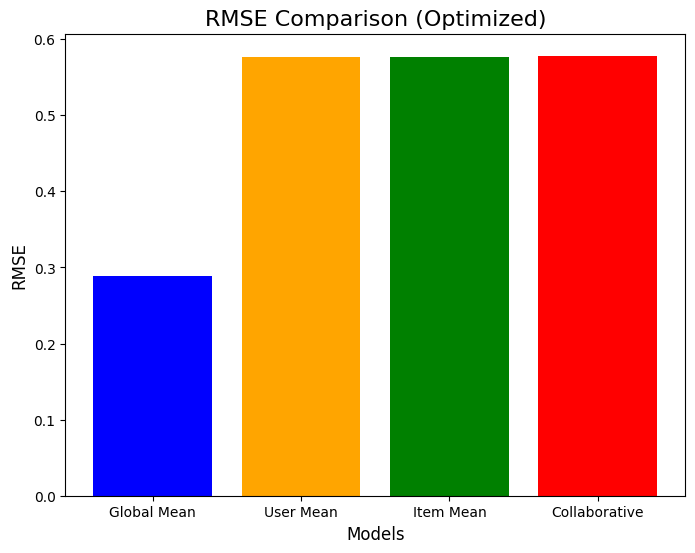

In [ ]:
# Train-Test Split with Subset
def create_train_test_split(sparse_matrix, test_size=0.2, subset_size=None):
    non_zero_indices = np.array(sparse_matrix.nonzero()).T
    non_zero_values = sparse_matrix[non_zero_indices[:, 0], non_zero_indices[:, 1]].A1

    if subset_size:
        non_zero_indices = non_zero_indices[:subset_size]
        non_zero_values = non_zero_values[:subset_size]

    train_indices, test_indices, train_values, test_values = train_test_split(
        non_zero_indices, non_zero_values, test_size=test_size, random_state=42
    )

    train_data = sp.csr_matrix(
        (train_values, (train_indices[:, 0], train_indices[:, 1])), shape=sparse_matrix.shape
    )
    test_data = sp.csr_matrix(
        (test_values, (test_indices[:, 0], test_indices[:, 1])), shape=sparse_matrix.shape
    )
    return train_data, test_data, test_indices

# Create train and test datasets
subset_size = 100000
train_data, test_data, test_indices = create_train_test_split(user_item_sparse, subset_size=subset_size)

# Calculate Baseline Predictions
def calculate_baselines(train_data, test_indices):
    global_mean = train_data.data.mean()

    user_means = np.array(train_data.mean(axis=1)).flatten()
    item_means = np.array(train_data.mean(axis=0)).flatten()

    global_predictions = np.full(test_indices.shape[0], global_mean)
    user_predictions = user_means[test_indices[:, 0]]
    item_predictions = item_means[test_indices[:, 1]]

    return global_predictions, user_predictions, item_predictions

global_predictions, user_predictions, item_predictions = calculate_baselines(train_data, test_indices)

# Truncated SVD for Collaborative Filtering
def collaborative_filtering(train_data, test_indices, n_components=100):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    train_svd = svd.fit_transform(train_data)

    predicted_matrix = np.dot(train_svd, svd.components_)
    collab_predictions = predicted_matrix[test_indices[:, 0], test_indices[:, 1]]
    return collab_predictions

collab_predictions = collaborative_filtering(train_data, test_indices, n_components=100)

# Calculate RMSE with Batch Processing
def calculate_rmse(actual_ratings, predictions, batch_size=1000):
    rmse_batches = []
    for i in range(0, len(actual_ratings), batch_size):
        actual_batch = actual_ratings[i:i + batch_size]
        pred_batch = predictions[i:i + batch_size]
        rmse_batches.append(mean_squared_error(actual_batch, pred_batch, squared=False))
    return np.mean(rmse_batches)

actual_ratings = test_data.data

rmse_global = calculate_rmse(actual_ratings, global_predictions)
rmse_user = calculate_rmse(actual_ratings, user_predictions)
rmse_item = calculate_rmse(actual_ratings, item_predictions)
rmse_collab = calculate_rmse(actual_ratings, collab_predictions)

# Plot Root mean square
def plot_rmse_comparison(models, rmses):
    plt.figure(figsize=(8, 6))
    plt.bar(models, rmses, color=["blue", "orange", "green", "red"])
    plt.title("RMSE Comparison (Optimized)", fontsize=16)
    plt.ylabel("RMSE", fontsize=12)
    plt.xlabel("Models", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

models = ["Global Mean", "User Mean", "Item Mean", "Collaborative"]
rmses = [rmse_global, rmse_user, rmse_item, rmse_collab]

plot_rmse_comparison(models, rmses)



